In [4]:
config_path = r"C:\Users\Patrick\Documents\TU\2019S\ML\ML_Exercise3\ML_Exercise3\config.yaml"
import datetime
import pandas as pd
from matplotlib import pyplot as plt
import glob, os
from PIL import Image
import yaml
import numpy as np
import cv2
from sklearn import preprocessing

%matplotlib inline

def get_config(config_path:str) :
    with open(config_path, 'r') as ymlfile:
        cfg = yaml.load(ymlfile)
    return cfg

_config = get_config(config_path)

os.chdir(_config["fruits-image-path"])
fileNames = glob.glob("*/*.jpg")
numberOfFiles=len(fileNames)
targetLabels=[]

print("Found " + str(numberOfFiles) + " files\n")

# The first step - create the ground truth (label assignment, target, ...) 
for fileName in fileNames:
    pathSepIndex = fileName.index("\\")
    targetLabels.append(fileName[:pathSepIndex])
distinct_target_labels = pd.Series(targetLabels).unique()

le = preprocessing.LabelEncoder()
le.fit(targetLabels)
target = le.transform(targetLabels) 
print("... done label encoding")

Found 971 files

... done label encoding


c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\ipykernel_launcher.py:16: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  app.launch_new_instance()


Showing demo feature extraction on image C:\Users\Patrick\Documents\TU\2019S\ML\ML_Exercise3\ML_Exercise3\data\FIDS30\acerolas\10.jpg


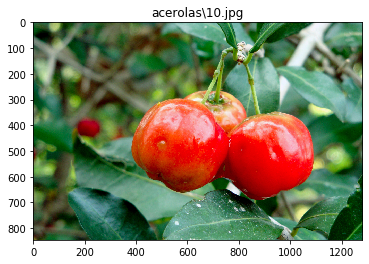

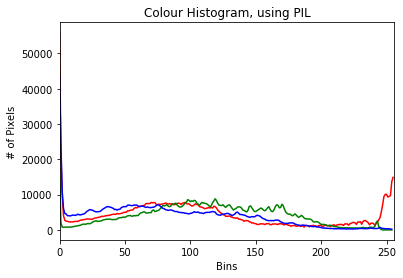

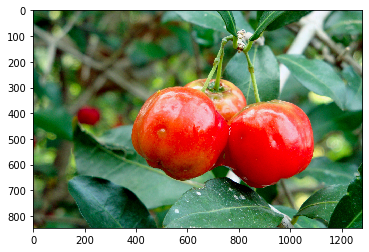

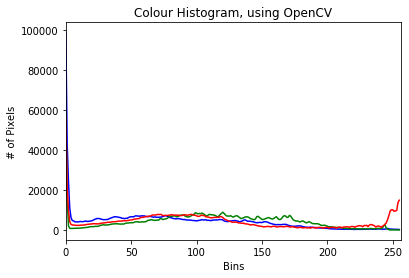

In [5]:
demoImageName = fileNames[1]
demoImage = os.path.join(_config["fruits-image-path"], demoImageName)
print("Showing demo feature extraction on image " + demoImage)
# load the image & plot it
imagePIL = Image.open(demoImage)
imgplot = plt.imshow(imagePIL)
plt.title(demoImageName)
featureVector=imagePIL.histogram()

# We plot this histogram
plt.figure()
plt.plot(featureVector[:256], 'r')
plt.plot(featureVector[257:512], 'g')
plt.plot(featureVector[513:], 'b')
plt.xlim([0, 256])
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
plt.title("Colour Histogram, using PIL")

# An alternative is to use open CV
imageOpenCV = cv2.imread(demoImage)
plt.figure()
plt.imshow(cv2.cvtColor(imageOpenCV, cv2.COLOR_BGR2RGB))

chans = cv2.split(imageOpenCV) # split the image in the different channels (RGB, but in open CV, it is BGR, actually..)
colors = ("b", "g", "r")
plt.figure()
plt.title("Colour Histogram, using OpenCV")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
featuresOpenCV = []

# loop over the image channels
for (chan, color) in zip(chans, colors):
    # create a histogram for the current channel and add it to the resulting histograms array (of arrays)
    histOpenCV = cv2.calcHist([chan], [0], None, [256], [0, 256])
    featuresOpenCV.extend(histOpenCV)
    plt.plot(histOpenCV, color = color)
    plt.xlim([0, 256])

featureVectorOpenCV = np.array(featuresOpenCV).flatten()
plt.show()

In [6]:
data=[]
for index, fileName in enumerate(fileNames):
    imagePIL = Image.open(os.path.join(_config["fruits-image-path"], fileName))
    # Not all images in our dataset are in RGB color scheme (e.g. indexed colours)
    # We need to make sure that they are RGB , otherwise we can't expect to have exactly three RGB channels..
    imagePIL = imagePIL.convert('RGB')     
    featureVector=imagePIL.histogram()
    
    if (len(featureVector) != 768): # just a sanity check; with the transformation to RGB, this should never happen
        print("Unexpected length of feature vector: " + str(len(featureVector)) + " in file: " + fileName)

    data.append((featureVector))

print("Extracting features using OpenCV" + " (" + str(datetime.datetime.now()) + ")")
dataOpenCV_1D=[]
dataOpenCV_2D=[]
dataOpenCV_3D=[]

# use our own simple function to flatten the 2D arrays
flatten = lambda l: [item for sublist in l for item in sublist]

for fileName in fileNames:

    imagePIL = Image.open(os.path.join(_config["fruits-image-path"], fileName))
    imagePIL = imagePIL.convert('RGB')
    imageOpenCV = np.array(imagePIL) 
    # Convert RGB to BGR 
    imageOpenCV = imageOpenCV[:, :, ::-1].copy() 

    # Now we split the image in the three channels, B / G / R
    chans = cv2.split(imageOpenCV)
    colors = ("b", "g", "r")

    # First we do also features per channel, but this time, we aggregate them into a smaller number of bins
    # I.e. we do not have 256 values per channel, but less
    featuresOpenCV_1D = []
    bins_1D=64
    for (chan, color) in zip(chans, colors): # we compute the histogram over each channel
        histOpenCV = cv2.calcHist([chan], [0], None, [bins_1D], [0, 256])
        featuresOpenCV_1D.extend(histOpenCV)
    featureVectorOpenCV_1D = flatten(featuresOpenCV_1D) # and append this to our feature vector
    
    dataOpenCV_1D.append(featureVectorOpenCV_1D) # now we append the feature vector to the dataset so far

    if (len(featureVectorOpenCV_1D) != bins_1D*3): # sanity check, in case we had a wrong number of channels...
        print("Unexpected length of feature vector: " + str(len(featureVectorOpenCV_1D)) + " in file: " + fileName)

    # Next - features that look at two channels at the same time
    # We reduce the size of bins further, to not have a too long feature vector
    featuresOpenCV_2D = []
    bins2D=16
    # look at all combinations of channels (R & B, R & G, B & G)
    featuresOpenCV_2D.extend(cv2.calcHist([chans[1], chans[0]], [0, 1], None, [bins2D, bins2D], [0, 256, 0, 256]))
    featuresOpenCV_2D.extend(cv2.calcHist([chans[1], chans[2]], [0, 1], None, [bins2D, bins2D], [0, 256, 0, 256]))
    featuresOpenCV_2D.extend(cv2.calcHist([chans[0], chans[2]], [0, 1], None, [bins2D, bins2D], [0, 256, 0, 256]))
    # and add that to our dataset
    featureVectorOpenCV_2D = flatten(featuresOpenCV_2D)
    dataOpenCV_2D.append(featureVectorOpenCV_2D)

    # finally, we look at all three channels at the same time.
    # We further reduce our bin size, because otherwise, this would become very large...
    featuresOpenCV_3D = cv2.calcHist([imageOpenCV], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    # append to our dataset
    featureVectorOpenCV_3D = featuresOpenCV_3D.flatten()
    dataOpenCV_3D.append(featureVectorOpenCV_3D)
        
print(".... done" + " (" + str(datetime.datetime.now()) + ")")

Extracting features using OpenCV (2019-07-30 18:09:53.091059)
.... done (2019-07-30 18:10:51.769256)


In [7]:
from sklearn.model_selection import cross_val_score, train_test_split

from sklearn import neighbors
from sklearn import naive_bayes
from sklearn import tree
from sklearn import ensemble
from sklearn import svm
from sklearn import neural_network
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [8]:
# these are our feature sets; we will use each of them individually to train classifiers
trainingSets = [data, dataOpenCV_1D, dataOpenCV_2D, dataOpenCV_3D]

# set up a number of classifiers
classifiers = [("Kneighbors", neighbors.KNeighborsClassifier()),
               ('GaussianNB', naive_bayes.GaussianNB()), 
               ('DecisionTree', tree.DecisionTreeClassifier()),
               ('RandomForest', ensemble.RandomForestClassifier()),
               ('RandomForest_OPT', ensemble.RandomForestClassifier(n_estimators=300)),
               ('SVC', svm.SVC()),
               ('MLP', neural_network.MLPClassifier()),
               ('MLP_OPT', neural_network.MLPClassifier(alpha=0.03, max_iter=500))
              ]
trainingSet_names = ['data', '1D', '2D', '3D']
# Now iterate over the datasets & classifiers, and train...
arr = []
times=[]
for iindex, train in enumerate(trainingSets):
    print("\n")
    for jindex, classifier_tuple in enumerate(classifiers):
        if iindex == 0:
            arr.append([])
            times.append([])
        print(classifier_tuple[0])
        start = datetime.datetime.now()
        scores = cross_val_score(classifier_tuple[1], train, target, cv=10)
        print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        arr[jindex].append(scores.mean())
        times[jindex].append((datetime.datetime.now() - start).seconds)
        
        X_train, X_test, y_train, y_test =  train_test_split(train, target, random_state=42)
        classifier_tuple[1].fit(X_train, y_train)
        y_pred = classifier_tuple[1].predict(X_test)
        fig, ax = plt.subplots(1, 1, figsize=(14, 14), dpi=200)
        plt.rcParams.update({'font.size': 15})
        cm = confusion_matrix(y_test, y_pred)
        df_cm = pd.DataFrame(cm, index=distinct_target_labels, columns=distinct_target_labels)
        g = sns.heatmap(df_cm, annot=True, ax=ax)
        a = plt.title('Confusion Matrix of ' + classifier_tuple[0] + ' for training set ' + trainingSet_names[iindex] + ' (Accuracy: ' + "{:.2f}".format(scores.mean()) + ')')
        g.get_figure().savefig(os.path.join(_config["plot-path"],'plots','cm_fruits__simple_'+trainingSet_names[iindex]+"_"+classifier_tuple[0]+"_{:.0f}".format(scores.mean()*100)+'.png'), bbox_inches='tight')
        plt.close()



Kneighbors
Accuracy: 0.10 (+/- 0.05)
GaussianNB
Accuracy: 0.07 (+/- 0.04)
DecisionTree
Accuracy: 0.14 (+/- 0.09)
RandomForest
Accuracy: 0.23 (+/- 0.05)
RandomForest_OPT
Accuracy: 0.29 (+/- 0.08)
SVC
Accuracy: 0.05 (+/- 0.01)
MLP
Accuracy: 0.16 (+/- 0.13)
MLP_OPT
Accuracy: 0.14 (+/- 0.08)


Kneighbors
Accuracy: 0.11 (+/- 0.05)
GaussianNB
Accuracy: 0.07 (+/- 0.05)
DecisionTree
Accuracy: 0.14 (+/- 0.09)
RandomForest
Accuracy: 0.22 (+/- 0.08)
RandomForest_OPT
Accuracy: 0.29 (+/- 0.07)
SVC
Accuracy: 0.05 (+/- 0.01)
MLP
Accuracy: 0.21 (+/- 0.11)
MLP_OPT
Accuracy: 0.21 (+/- 0.10)


Kneighbors
Accuracy: 0.16 (+/- 0.07)
GaussianNB
Accuracy: 0.21 (+/- 0.06)
DecisionTree
Accuracy: 0.29 (+/- 0.12)
RandomForest
Accuracy: 0.38 (+/- 0.08)
RandomForest_OPT
Accuracy: 0.50 (+/- 0.09)
SVC
Accuracy: 0.05 (+/- 0.01)
MLP
Accuracy: 0.33 (+/- 0.05)
MLP_OPT
Accuracy: 0.33 (+/- 0.11)


Kneighbors
Accuracy: 0.19 (+/- 0.07)
GaussianNB
Accuracy: 0.25 (+/- 0.08)
DecisionTree
Accuracy: 0.31 (+/- 0.07)
RandomForest

c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators wil

In [9]:
classifier_names = [clf_tuple[0] for clf_tuple in classifiers]
df = pd.DataFrame(data=arr, index=classifier_names,columns=trainingSet_names)
df_times = pd.DataFrame(data=times, index=classifier_names,columns=trainingSet_names)

([0, 1, 2, 3, 4, 5, 6, 7], <a list of 8 Text xticklabel objects>)

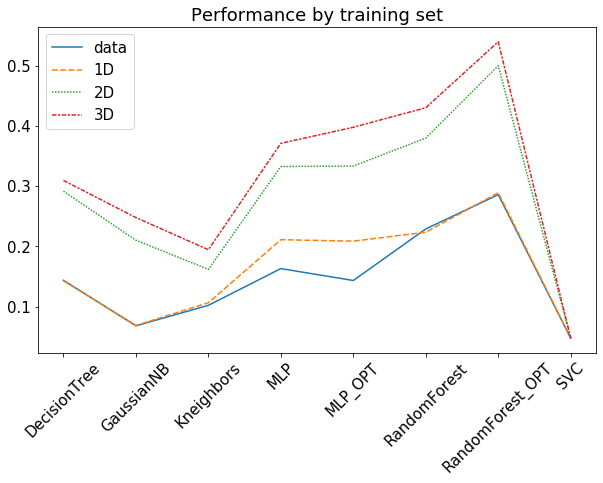

In [10]:
_, ax = plt.subplots(figsize=(10, 6))
plt.title('Performance by training set')
sns.lineplot(data=df, ax=ax)
plt.xticks(rotation=45)

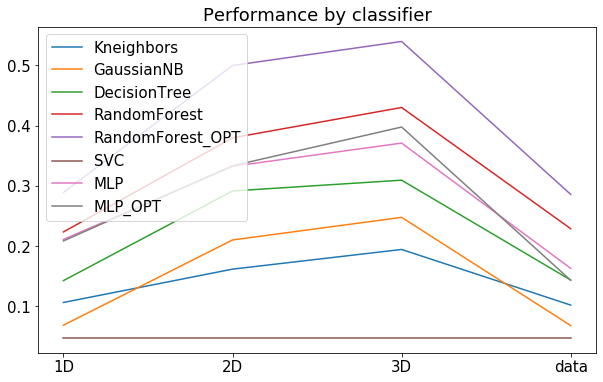

In [11]:
_, ax = plt.subplots(figsize=(10, 6))
plt.title('Performance by classifier')
sns.lineplot(data=df.T, ax=ax, dashes=False)

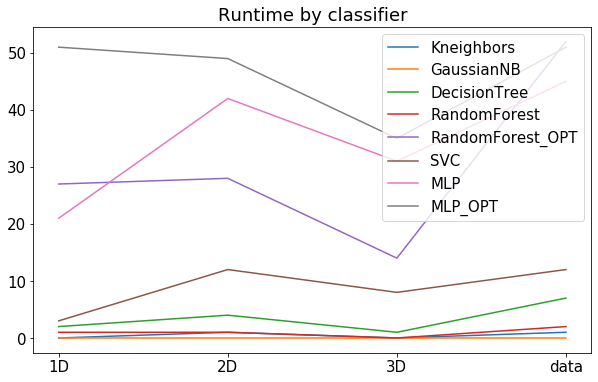

In [14]:
_, ax = plt.subplots(figsize=(10, 6))
plt.title('Runtime by classifier')
sns.lineplot(data=df_times.T, ax=ax, dashes=False)

In [15]:
# tune MLP and RandomForest using GridSearch
from sklearn.model_selection import GridSearchCV
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [16]:
rfclf_param_grid = {
  "n_estimators": [10, 100, 300],
  "max_depth": [5, 7, None],
  "max_features": [5, "auto"],
  }
rfclf = ensemble.RandomForestClassifier()
rfclf_grid_search = GridSearchCV(rfclf, param_grid=rfclf_param_grid, cv=10, n_jobs=1)
rfclf_grid_search.fit(dataOpenCV_3D, target)

report(rfclf_grid_search.cv_results_) 

df_gr = pd.DataFrame(rfclf_grid_search.cv_results_)
df_gr = df_gr[['mean_fit_time', 'mean_test_score', 'std_test_score', 'rank_test_score', 'param_max_depth', 'param_max_features', 'param_n_estimators']]
df_gr.index.name = 'id'
df_gr = df_gr.round(4)
df_gr.to_csv('grid_rfr_fruits.csv', sep=';', float_format='%.4f')

c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Model with rank: 1
Mean validation score: 0.549 (std: 0.034)
Parameters: {'max_depth': None, 'max_features': 'auto', 'n_estimators': 300}

Model with rank: 2
Mean validation score: 0.530 (std: 0.025)
Parameters: {'max_depth': None, 'max_features': 5, 'n_estimators': 300}

Model with rank: 3
Mean validation score: 0.522 (std: 0.036)
Parameters: {'max_depth': None, 'max_features': 'auto', 'n_estimators': 100}



In [17]:
mlpclf_param_grid = {"hidden_layer_sizes": [(100,), (100,30), (50,50)], #, (30, 30, 20), smaller ones e.g. 10; 15; 15,15 worse
              "activation": [ "relu"], #tanh worse
              "solver": ["adam"], #lbfgs worse
              "alpha": [0.001, 0.03], #0.0001, 0.005, 
              "max_iter": [100, 200, 500]} # 100 worse, does not converge
mlpclf = neural_network.MLPClassifier()
mlpclf_grid_search = GridSearchCV(mlpclf, param_grid=mlpclf_param_grid, cv=10, n_jobs=1)
mlpclf_grid_search.fit(dataOpenCV_3D, target)

report(mlpclf_grid_search.cv_results_) 

df_grm = pd.DataFrame(mlpclf_grid_search.cv_results_)
df_grm = df_grm[['mean_fit_time', 'mean_test_score', 'std_test_score', 'rank_test_score', 'param_hidden_layer_sizes', 'param_alpha', 'param_max_iter']]
df_grm.index.name = 'id'
df_grm = df_grm.round(4)
df_grm.to_csv('grid_mlp_fruits.csv', sep=';', float_format='%.4f')

c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\neural_net

Model with rank: 1
Mean validation score: 0.377 (std: 0.056)
Parameters: {'activation': 'relu', 'alpha': 0.03, 'hidden_layer_sizes': (100,), 'max_iter': 100, 'solver': 'adam'}

Model with rank: 2
Mean validation score: 0.372 (std: 0.040)
Parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'max_iter': 500, 'solver': 'adam'}

Model with rank: 3
Mean validation score: 0.367 (std: 0.045)
Parameters: {'activation': 'relu', 'alpha': 0.03, 'hidden_layer_sizes': (100,), 'max_iter': 200, 'solver': 'adam'}

